## 1. Load data

In [153]:
import os
import numpy as np
import librosa

#50 speakers audio data with length more than 1 hour for each. Wav format, 16KHz, mono channel and is split into 1min chunks. Scraped from YouTube and Librivox.
data_dir_path = '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data'


def load_images() -> (np.ndarray, np.ndarray, np.ndarray):
    print("[INFO] Loading data...")
    
    original_audio_files = []
    features = []
    labels = []
    
    i = 0
    for speaker_dir in os.listdir(data_dir_path):
        speaker_dir_path = os.path.join(data_dir_path, speaker_dir)
        speaker_id = speaker_dir[-4:]
        if i == 50:
            break
        i=i+1
        print(f"[INFO] Loading data for user {speaker_id}...")
        numb_of_samples = 0
        for audio_file in os.listdir(speaker_dir_path):
            audio_path = os.path.join(speaker_dir_path, audio_file)
            try:
                y, sr = librosa.load(audio_path, sr=16000)
                # cut the audio file
                y = y[:30*sr]
                spect = extract_mel_spectrogram(y, sr, False)
                # spect = extract_stft_spectrogram(y, sr, False)
                # spect = extract_MFCCs(y, sr, False)
                # spect = extract_spectral_centroid(y, False)
                # spect = extract_features_means(y, sr) # 1D tests
                if len(features) > 0 and features[-1].shape != spect.shape:
                    print(f"Shape of input file {audio_file} doesn't match previous one, skipping.")
                    continue
                
                features.append(spect)
                original_audio_files.append(y)
                labels.append(int(speaker_id))  # Assign label (speaker id)
                numb_of_samples = numb_of_samples + 1
                    
            except Exception as e:
                print(f"[ERROR] Error loading audio file: {audio_path}. Error: {e}")
        
        print(f"[INFO] Loaded a total of {numb_of_samples} samples for user {speaker_id}.")

    # Convert lists to numpy arrays for further processing and normalize
    features = np.array(features)
    labels = np.array(labels)
    
    # Print the shapes to verify
    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    
    print(f"[INFO] Loaded {features.shape[0]} files.")
    
    return features, labels, original_audio_files

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

def extract_MFCCs(y, sr, show_plt: bool) -> np.ndarray:    
    # MFCC — Mel-Frequency Cepstral Coefficients
    # This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.title('MFCC')
        plt.colorbar()
        plt.show() 
    
    return mfccs
    
def extract_stft_spectrogram(y, sr, show_plt: bool) -> np.ndarray:
    # Short Term Fourier Transform (STFT) converts signal such that we can know the amplitude of given frequency at a given time. 
    # It has all the frequency bands from the FFT, (n_fft/2)+1 bands, 1025 for n_fft=2048.
    stft = librosa.stft(y, hop_length=1024) # hop_length - number of audio samples between adjacent STFT columns.
    
    # You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. There are some additional details going on behind the scenes when computing the spectrogram. The y-axis is converted to a log scale, and the color dimension is converted to decibels (you can think of this as the log scale of the amplitude). This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.
    spect = np.abs(stft)
    spect = librosa.amplitude_to_db(spect, ref=np.max) # Convert an amplitude spectrogram to dB-scaled spectrogram.
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(spect, sr=sr, x_axis='time', y_axis='log')
        plt.title('Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show() 
        
    return spect

def extract_mel_spectrogram(y, sr, show_plt: bool) -> np.ndarray:
    # We are better at detecting differences in lower frequencies than higher frequencies.
    # A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.
    
    # Where-as the mel-spectrogram has mel filters applied which reduces the number of bands to n_mels (typically 32-128)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024, n_mels=128)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mel_spect, sr=sr, y_axis='mel', fmax=8000, x_axis='time')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        
    return mel_spect

# very high overfitting factor -> no sense
def extract_spectral_centroid(y, show_plt: bool) -> np.ndarray:
    # Spectral Centroid 
    # It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. If the frequencies in music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.
    
    stft = librosa.stft(y, hop_length=1024) # hop_length - number of audio samples between adjacent STFT columns.
    spectrogram = np.abs(stft)
    
    spectral_centroids = librosa.feature.spectral_centroid(S=spectrogram)
    
    times = librosa.times_like(spectral_centroids)
    
    if show_plt:
        fig, ax = plt.subplots(figsize=(14, 5))
        librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),  y_axis='log', x_axis='time', ax=ax)
        
        ax.plot(times, spectral_centroids.T, label='Spectral centroid', color='w')
        ax.legend(loc='upper right')
        ax.set(title='log Power spectrogram')
        plt.show()
    
    return spectral_centroids

def extract_chroma_stft(y, sr) -> np.ndarray:
    stft = np.abs(librosa.stft(y, hop_length=1024))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    
    return chroma_stft

def extract_spectral_contrast(y, sr) -> np.ndarray:
    stft = np.abs(librosa.stft(y, hop_length=1024))
    spec_contr = librosa.feature.spectral_contrast(S=stft, sr=sr)
    
    return spec_contr

def extract_features_means(y, sr) -> np.ndarray:
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = extract_MFCCs(y, sr, False)
    mfccs = np.mean(mfccs.T, axis=0)

    # Computes a mel-scaled spectrogram.
    mel = extract_mel_spectrogram(y, sr, False)
    mel = np.mean(mel.T, axis=0)

    # Computes spectral contrast
    spec_contr = extract_spectral_contrast(y, sr)
    spec_contr = np.mean(spec_contr.T, axis=0)

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = extract_chroma_stft(y, sr)
    chroma = np.mean(chroma.T, axis=0)

    # Computes the tonal centroid features (tonnetz)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

    return np.concatenate((mfccs, mel, spec_contr, chroma))
    
       
       
def print_waveform(y):
    plt.figure(figsize=(14, 5))
    plt.plot(y)
    plt.title('Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

## Onehot encode

In [155]:
from sklearn.preprocessing import OneHotEncoder

# Perform one-hot encoding for the labels convert to one-valued arr
def onehot_encode(labels: np.ndarray) -> (np.ndarray, dict):
    print("[INFO] Performing one-hot encoding on multiple nodes...")
    # Version 2 -> n nodes
    encoder = OneHotEncoder()
    labels = np.array(labels).reshape(-1, 1)
    labels_onehot = encoder.fit_transform(labels)
    labels_onehot = labels_onehot.astype(float) # convert to float
    labels_onehot = labels_onehot.toarray()
    
    # Display the mapping between original classes and one-hot encoded columns
    original_classes = encoder.categories_[0]
    mapping = {col_idx: class_label for col_idx, class_label in enumerate(original_classes)}
    print("Mapping between column indices and original classes:")
    print(mapping)
    
    print("Labels encoded using OneHotEncoder(), labels.shape:", labels_onehot.shape)
    
    return labels_onehot, mapping

## Model evaluation

In [206]:
from scipy.interpolate import make_interp_spline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

def evaluate_model(H, y_pred, y_test, n_of_epochs):
    print("[INFO] Evaluating model...")

    print(f'Type and shape of y_test: {type(y_test)} | {y_test.shape}')
    print(f'Type and shape of y_pred: {type(y_pred)} | {y_pred.shape}')
    
    print('\nConfusion matrix:') 
    print(confusion_matrix(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    
    fig, ax = plt.subplots(figsize=(15,15))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    ax.grid(False)
    disp.plot(ax=ax)
  
    print(classification_report(y_test, y_pred, zero_division=1))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred)*100:.1f}%")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.1f}%")
    
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure(figsize=(14,8))
    
    epochs_x = np.arange(0, n_of_epochs)
    X_ = np.linspace(epochs_x.min(), epochs_x.max(), 250)
    
    plt.plot(X_, return_interpolated_plot(H.history["loss"], epochs_x, X_), label="train_loss")
    plt.plot(X_, return_interpolated_plot(H.history["val_loss"], epochs_x, X_), label="val_loss")
    plt.plot(X_, return_interpolated_plot(H.history["accuracy"], epochs_x, X_), label="train_acc")
    plt.plot(X_, return_interpolated_plot(H.history["val_accuracy"], epochs_x, X_), label="val_acc")
    
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    
def return_interpolated_plot(y, x, X_):
    X_Y_Spline = make_interp_spline(x , y)
    Y_ = X_Y_Spline(X_)
 
    return Y_

## ------

In [157]:
features, labels, original_audio_files = load_images()

[INFO] Loading data...
[INFO] Loading data for user 0026...
Shape of input file Speaker26_044.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0027...
Shape of input file Speaker27_046.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0028...
Shape of input file Speaker28_058.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0029...
Shape of input file Speaker29_030.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0030...
Shape of input file Speaker30_032.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0031...
[INFO] Loading data for user 0032...
[INFO] Loading data for user 0033...
[INFO] Loading data for user 0034...
[INFO] Loading data for user 0035...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2112) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2368) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

[INFO] Loading data for user 0036...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1984) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2720) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1952) too large for available bit count (1568)


Shape of input file Speaker0036_032.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0037...
Shape of input file Speaker0037_054.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0038...
Shape of input file Speaker0038_033.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0039...
[INFO] Loading data for user 0040...
[INFO] Loading data for user 0041...
[INFO] Loading data for user 0042...
Shape of input file Speaker0042_040.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0043...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1696) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1888) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2176) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

Shape of input file Speaker0043_033.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0044...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2112) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1696) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2144) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

Shape of input file Speaker0044_036.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0045...
Shape of input file Speaker0045_041.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0046...
[INFO] Loading data for user 0047...
[INFO] Loading data for user 0048...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2176) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2752) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1568) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1952) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)


Shape of input file Speaker0048_030.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0049...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1824) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1984) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1568) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2656) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771]

Shape of input file Speaker0049_049.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0050...
Shape of input file Speaker0050_032.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0000...
[INFO] Loading data for user 0001...
[INFO] Loading data for user 0002...
Shape of input file Speaker_0002_00119.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0003...
Shape of input file Speaker_0003_00084.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0004...
Shape of input file Speaker_0004_00089.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0005...
[INFO] Loading data for user 0006...
Shape of input file Speaker_0006_00075.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0007...
[INFO] Loading data for user 0008...
[INFO] Loading data for user 0009...
Shape of input file Speaker_0009_00064.wav doesn't match previous one, skipping.
[INFO] Loading data for user 001

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1664) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2688) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)


[INFO] Loading data for user 0021...
Shape of input file Speaker_0021_00057.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0023...
Shape of input file Speaker_0023_00038.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0024...
Shape of input file Speaker_0024_00053.wav doesn't match previous one, skipping.
[INFO] Loading data for user 0025...
Shape of input file Speaker_0025_00048.wav doesn't match previous one, skipping.
Features shape: (2480, 128, 469)
Labels shape: (2480,)
[INFO] Loaded 2480 files.


[INFO] Plotting sample features...


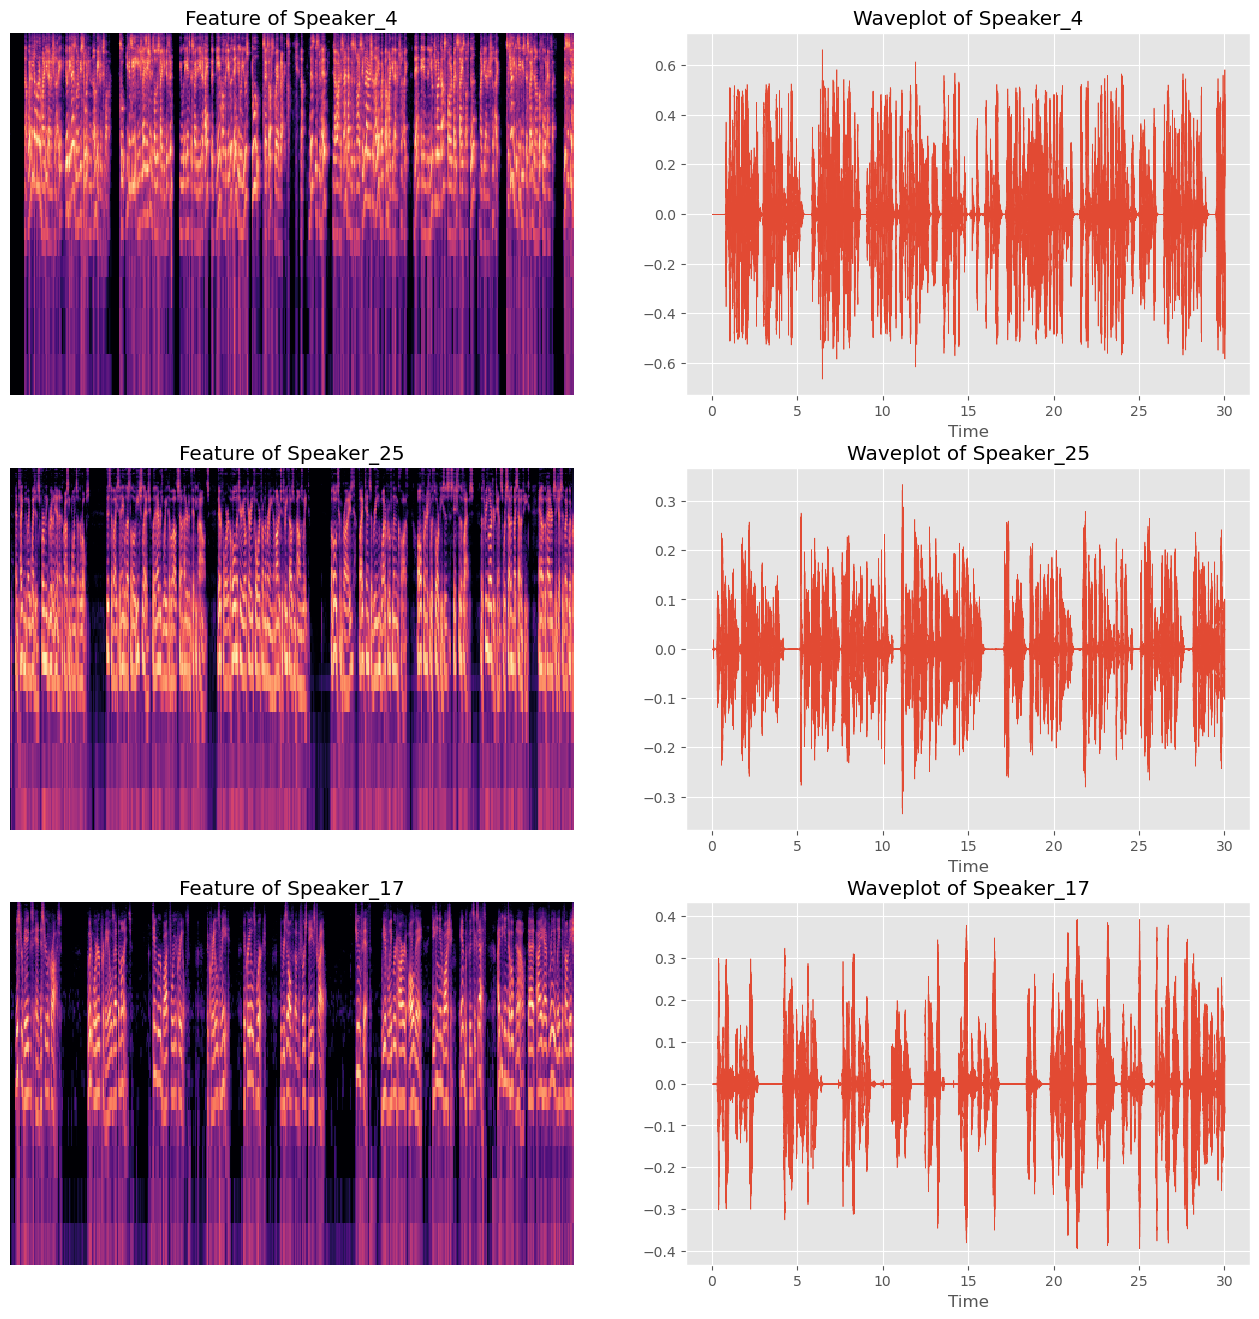

In [173]:
import random

print("[INFO] Plotting sample features...")

plt.figure(figsize=(16, 16))

for i in range(3):
    n = random.randrange(len(features))
    plt.subplot(3, 2, 2*i + 1)
    librosa.display.specshow(features[n], sr=16000, x_axis='time', y_axis='log')
    plt.title(f'Feature of Speaker_{labels[n]}')
    plt.axis("off")
    
    plt.subplot(3, 2, 2*i + 2)
    librosa.display.waveshow(original_audio_files[n], sr=16000)
    plt.title(f'Waveplot of Speaker_{labels[n]}')


## Encode Labels

In [159]:
labels_onehot, class_onehot_mapping = onehot_encode(labels)

[INFO] Performing one-hot encoding on multiple nodes...
Mapping between column indices and original classes:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50}
Labels encoded using OneHotEncoder(), labels.shape: (2480, 50)


## Split train and test data

In [169]:
from sklearn.model_selection import train_test_split

# train:test 70:30
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.30, random_state=32)

# test:val 40:60
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.60, random_state=32)


print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the validation set: {X_val.shape}')
print(f'Shape of the test set: {X_test.shape}')

Shape of the training set: (1736, 128, 469)
Shape of the validation set: (447, 128, 469)
Shape of the test set: (297, 128, 469)


## Build a CNN model

In [170]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

feature_width, feature_height = X_train.shape[1:3]

classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    # This layer extracts 64 different 3x3 features
    # Typically you’ll see strides of 2×2 as a replacement to max pooling:
    Conv2D(64, (3, 3), input_shape=(feature_width, feature_height, 1), padding="same", activation='relu'),
    Conv2D(64, (3, 3), strides=(4, 4), padding="same", activation='relu'),
    Dropout(0.25), # Dropout helps generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.
     
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=(4, 4), padding='same', activation='relu'),
    Dropout(0.25),
     
    Flatten(),
    
    # # Use ReLU to avoid vanishing gradients problem
    Dense(1024, activation='relu'),
    Dropout(0.25),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25), #using a drop outs to avoid stepping to local minimums and labeling all samples to one class

    Dense(classes, activation='softmax'), # Categorical Classification: using softmax - multiple output nodes
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 469, 64)      640       
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 118, 64)       36928     
                                                                 
 dropout_29 (Dropout)        (None, 32, 118, 64)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 118, 128)      73856     
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 30, 128)        147584    
                                                                 
 dropout_30 (Dropout)        (None, 8, 30, 128)        0         
                                                                 
 flatten_7 (Flatten)         (None, 30720)            

In [171]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.001)
# crossentropy - Probabilistic losses
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#checkpoint = ModelCheckpoint('best_model_256.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# 1. *batch size* - defines the number of samples that will be propagated through the network. default 32
# one epoch = one forward pass and one backward pass of all the training examples batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
epochs=30

H = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val)) 

Epoch 1/30


2023-11-24 19:42:27.311058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


55/55 [==============================] - 3s 32ms/step - loss: 4.3710 - accuracy: 0.0397 - val_loss: 3.8181 - val_accuracy: 0.0447
Epoch 2/30
55/55 [==============================] - 2s 29ms/step - loss: 3.7260 - accuracy: 0.0386 - val_loss: 3.5356 - val_accuracy: 0.0224
Epoch 3/30
55/55 [==============================] - 2s 28ms/step - loss: 3.5245 - accuracy: 0.0380 - val_loss: 3.3632 - val_accuracy: 0.0380
Epoch 4/30
55/55 [==============================] - 2s 28ms/step - loss: 3.4363 - accuracy: 0.0570 - val_loss: 3.3584 - val_accuracy: 0.0716
Epoch 5/30
55/55 [==============================] - 2s 28ms/step - loss: 3.3375 - accuracy: 0.0611 - val_loss: 3.2374 - val_accuracy: 0.0537
Epoch 6/30
55/55 [==============================] - 2s 29ms/step - loss: 3.2852 - accuracy: 0.0605 - val_loss: 3.1652 - val_accuracy: 0.0582
Epoch 7/30
55/55 [==============================] - 2s 29ms/step - loss: 3.2056 - accuracy: 0.0812 - val_loss: 3.1320 - val_accuracy: 0.0492
Epoch 8/30
55/55 [======

10/10 [==============================] - 0s 26ms/step
Predicted | Actual |  Confidence   |
   34     |   34   |    99.99   %  |  ✔ 
   17     |   17   |    99.99   %  |  ✔ 
   44     |   44   |    100.00  %  |  ✔ 
   7      |   7    |    100.00  %  |  ✔ 
   2      |   2    |    92.67   %  |  ✔ 
   42     |   42   |    99.99   %  |  ✔ 
   39     |   39   |    99.62   %  |  ✔ 
   23     |   23   |    100.00  %  |  ✔ 
   7      |   7    |    100.00  %  |  ✔ 
   28     |   28   |    100.00  %  |  ✔ 
   2      |   2    |    91.87   %  |  ✔ 
   30     |   30   |    100.00  %  |  ✔ 
   4      |   4    |    99.81   %  |  ✔ 
   48     |   48   |    100.00  %  |  ✔ 
   11     |   11   |    100.00  %  |  ✔ 
   3      |   3    |    89.99   %  |  ✔ 
   1      |   1    |    100.00  %  |  ✔ 
   35     |   35   |    100.00  %  |  ✔ 
   44     |   44   |    100.00  %  |  ✔ 
   1      |   1    |    99.97   %  |  ✔ 
   2      |   2    |    93.97   %  |  ✔ 
   26     |   26   |    99.98   %  |  ✔ 
   3   

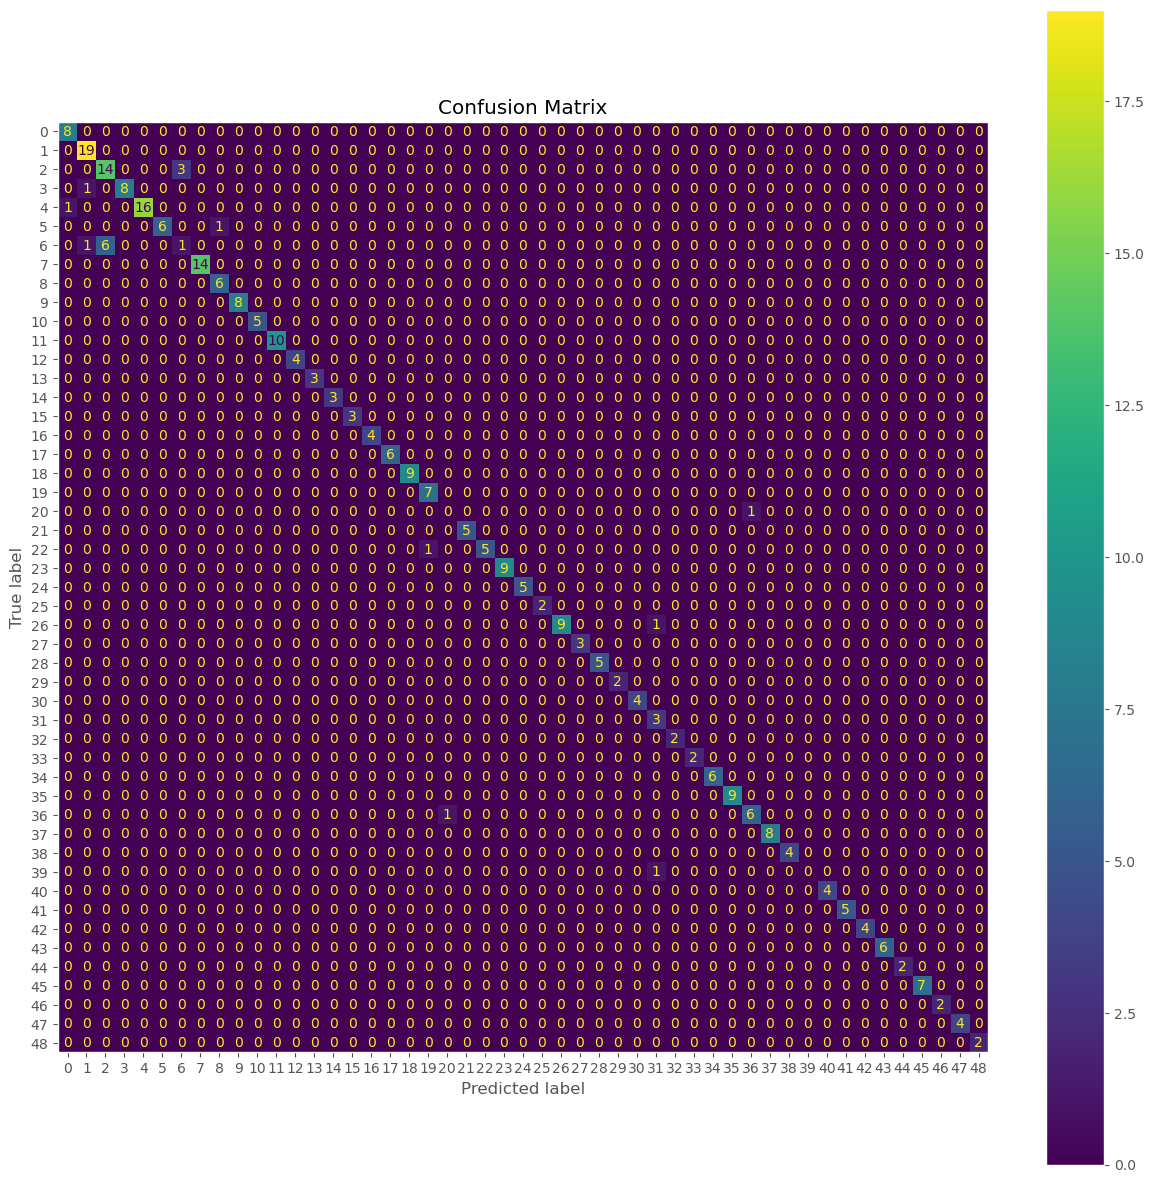

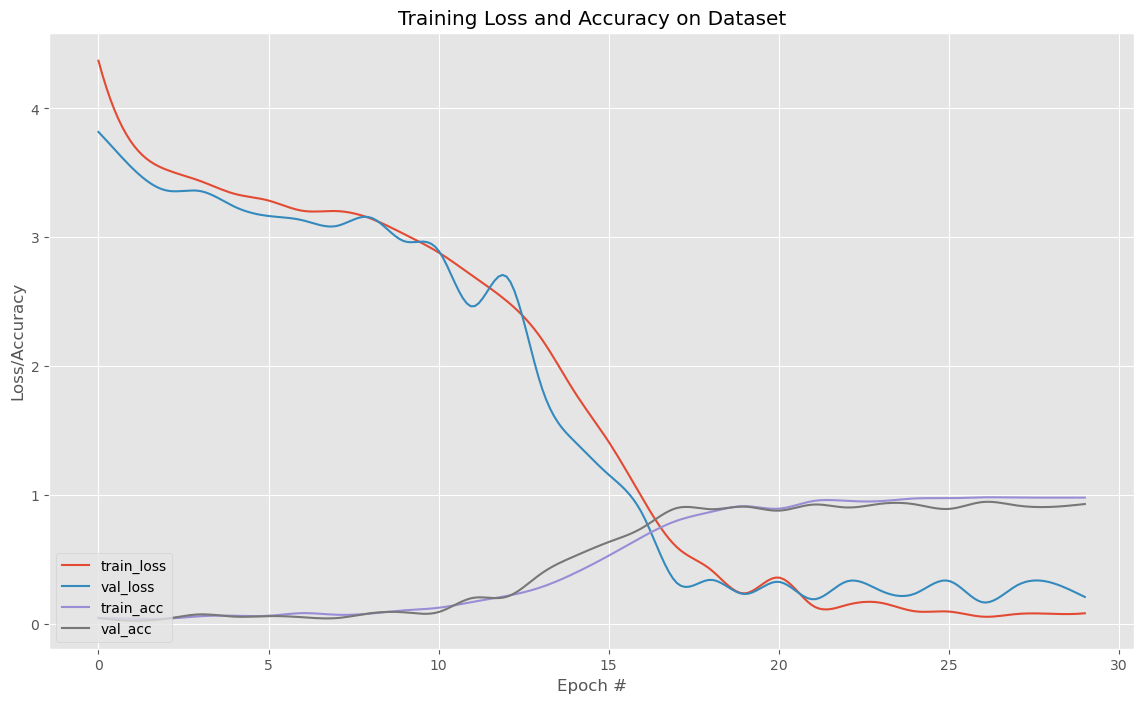

In [208]:
y_pred = model.predict(X_test)

y_pred_confidence = np.max(y_pred, axis=1)


y_pred = np.argmax(y_pred, axis=1) # softmax predictions need to be rounded 
y_pred = np.array(y_pred.tolist()) 

if y_pred.shape != y_test.shape:
    y_test = np.argmax(y_test, axis=1) 
    y_test = np.array(y_test.tolist()) 


print('Predicted | Actual |  Confidence   |')
for i in range(0, len(y_pred)):
    correct = '✔' if y_pred[i] == y_test[i] else '✘'
    print(f'{y_pred[i]:^8}  |  {y_test[i]:^4}  |  {y_pred_confidence[i]*100:^10.2f}%  |  {correct:^2}')
        
    
evaluate_model(H, y_pred, y_test, epochs)